In [1]:
from glob import glob
import json
import pandas as pd

files = glob('./output/experiments_sparsity/sparsity_*.json')

all_dicts = []

for file in files:
    with open(file, "r") as f:
        data = json.load(f)
        all_dicts.append(data)

df = pd.DataFrame(all_dicts)

df

,epochs,training_accuracy,test_accuracy,sparsity,time
0,30,0.821429,54.107774,0.8,1430.826547
1,30,0.964286,62.411661,0.2,2127.790000
2,30,0.964286,66.916961,0.0,1762.719051
3,30,0.857143,52.561837,0.6,1439.747979


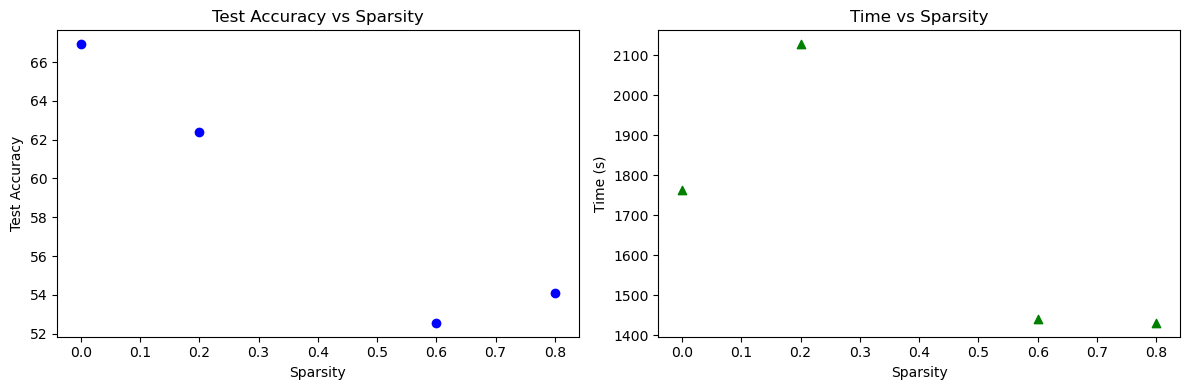

In [2]:
import matplotlib.pyplot as plt

x = df["sparsity"]
test_acc = df["test_accuracy"]
time = df["time"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Plot test accuracy
axes[0].scatter(x, test_acc, marker='o', color='blue')
axes[0].set_title("Test Accuracy vs Sparsity")
axes[0].set_xlabel("Sparsity")
axes[0].set_ylabel("Test Accuracy")

# Plot time
axes[1].scatter(x, time, marker='^', color='green')
axes[1].set_title("Time vs Sparsity")
axes[1].set_xlabel("Sparsity")
axes[1].set_ylabel("Time (s)")

plt.tight_layout()
plt.show()


In [5]:
df["time"].sum()/60

112.68472628333332

# Sparsity in Configurable Neural Net

In [1]:
from neural_nets.configurable_spiking_neural_net import ConfigurableSpikingNeuralNet
from constants import NUMBER_INPUT_NEURONS, NUMBER_OUTPUT_NEURONS, TIME_STEPS
from util.plot_layer_development import plot_layer_development
import torch
import copy 
from training.train_snn import train_snn

SPARSITIES = [0.5, 0.95]
beta = 0.99
threshold = 1

for sparsity in SPARSITIES:

    configured_net =  ConfigurableSpikingNeuralNet(number_input_neurons=NUMBER_INPUT_NEURONS,
                                                    number_hidden_neurons=100,
                                                    number_output_neurons=NUMBER_OUTPUT_NEURONS,
                                                    beta=beta,
                                                    threshold=threshold,
                                                    time_steps=TIME_STEPS,
                                                    number_hidden_layers=1)

    train_snn(configured_net, 
                sparsity=sparsity,
                num_epochs=2, 
                save_model=f'./models/test_sparsity_{sparsity}', 
                save_plots=f'./output/test_sparsity_{sparsity}', 
                additional_output_information={
                    'num_hidden_layer': 1,
                    'num_hidden_neurons': 100,
                    'sparsity': sparsity,
                    'beta': beta,
                    'threshold': threshold
                },
                output_file_path=f'./output/experiments_layer_development_investigation/test_sparsity_{sparsity}.json')
    




/home/mark/anaconda3/envs/whk-snn/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pruned layer 0 — sparsity: 50.00%
Pruned layer 1 — sparsity: 50.00%
Epoch: 0
loss 277.4060503485859
train accuracy 0.16920058852378617
test accuracy 23.0565371024735
Epoch: 1
loss 225.787608746748
train accuracy 0.24693477194703287
test accuracy 28.62190812720848
linears.0.bias: 0/100 (0.00%) zeros
linears.0.weight: 35000/70000 (50.00%) zeros
linears.1.bias: 0/20 (0.00%) zeros
linears.1.weight: 1000/2000 (50.00%) zeros

Total sparsity: 49.92% (36000/72120)
Pruned layer 0 — sparsity: 95.00%
Pruned layer 1 — sparsity: 95.00%
Epoch: 0
loss 316.39863144152883
train accuracy 0.06633153506620892
test accuracy 9.584805653710248
Epoch: 1
loss 282.62705852214816
train accuracy 0.12346738597351643
test accuracy 15.06183745583039
linears.0.bias: 0/100 (0.00%) zeros
linears.0.weight: 66500/70000 (95.00%) zeros
linears.1.bias: 0/20 (0.00%) zeros
linears.1.weight: 1900/2000 (95.00%) zeros

Total sparsity: 94.84% (68400/72120)


In [2]:
model05 = copy.deepcopy(configured_net)
model05.load_state_dict(torch.load(f'./models/test_sparsity_0.5.pth'))

model0 = copy.deepcopy(configured_net)
model0.load_state_dict(torch.load(f'./models/test_sparsity_0.pth'))

model095 = copy.deepcopy(configured_net)
model095.load_state_dict(torch.load(f'./models/test_sparsity_0.95.pth'))

models = [model0, model05, model095]

In [3]:
def count_zeros(model):
    total_params = 0
    zero_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            numel = param.numel()
            zeros = torch.sum(param == 0).item()
            total_params += numel
            zero_params += zeros
            print(f"{name}: {zeros}/{numel} ({100.0 * zeros / numel:.2f}%) zeros")
    print(f"\nTotal sparsity: {100.0 * zero_params / total_params:.2f}% ({zero_params}/{total_params})")


In [4]:
for model in models:
    count_zeros(model)

linears.0.bias: 0/100 (0.00%) zeros
linears.0.weight: 0/70000 (0.00%) zeros
linears.1.bias: 0/20 (0.00%) zeros
linears.1.weight: 0/2000 (0.00%) zeros

Total sparsity: 0.00% (0/72120)
linears.0.bias: 0/100 (0.00%) zeros
linears.0.weight: 35000/70000 (50.00%) zeros
linears.1.bias: 0/20 (0.00%) zeros
linears.1.weight: 1000/2000 (50.00%) zeros

Total sparsity: 49.92% (36000/72120)
linears.0.bias: 0/100 (0.00%) zeros
linears.0.weight: 66500/70000 (95.00%) zeros
linears.1.bias: 0/20 (0.00%) zeros
linears.1.weight: 1900/2000 (95.00%) zeros

Total sparsity: 94.84% (68400/72120)


In [5]:
import torch
from util.get_device import get_device
from torch.utils.data import DataLoader
from tonic import datasets, transforms
from constants import TIME_STEPS

selection_index = 2
device = get_device()

frame_transform = transforms.ToFrame(
    sensor_size=datasets.SHD.sensor_size,  
    n_time_bins=TIME_STEPS
)

test_data = datasets.SHD("./data", transform=frame_transform, train=False)

test_data_loader = DataLoader(test_data, shuffle=False, batch_size=32)

data, target = list(test_data_loader)[0]
data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(device)

x_selected = data[:, selection_index, :]
y_selected = target[selection_index]


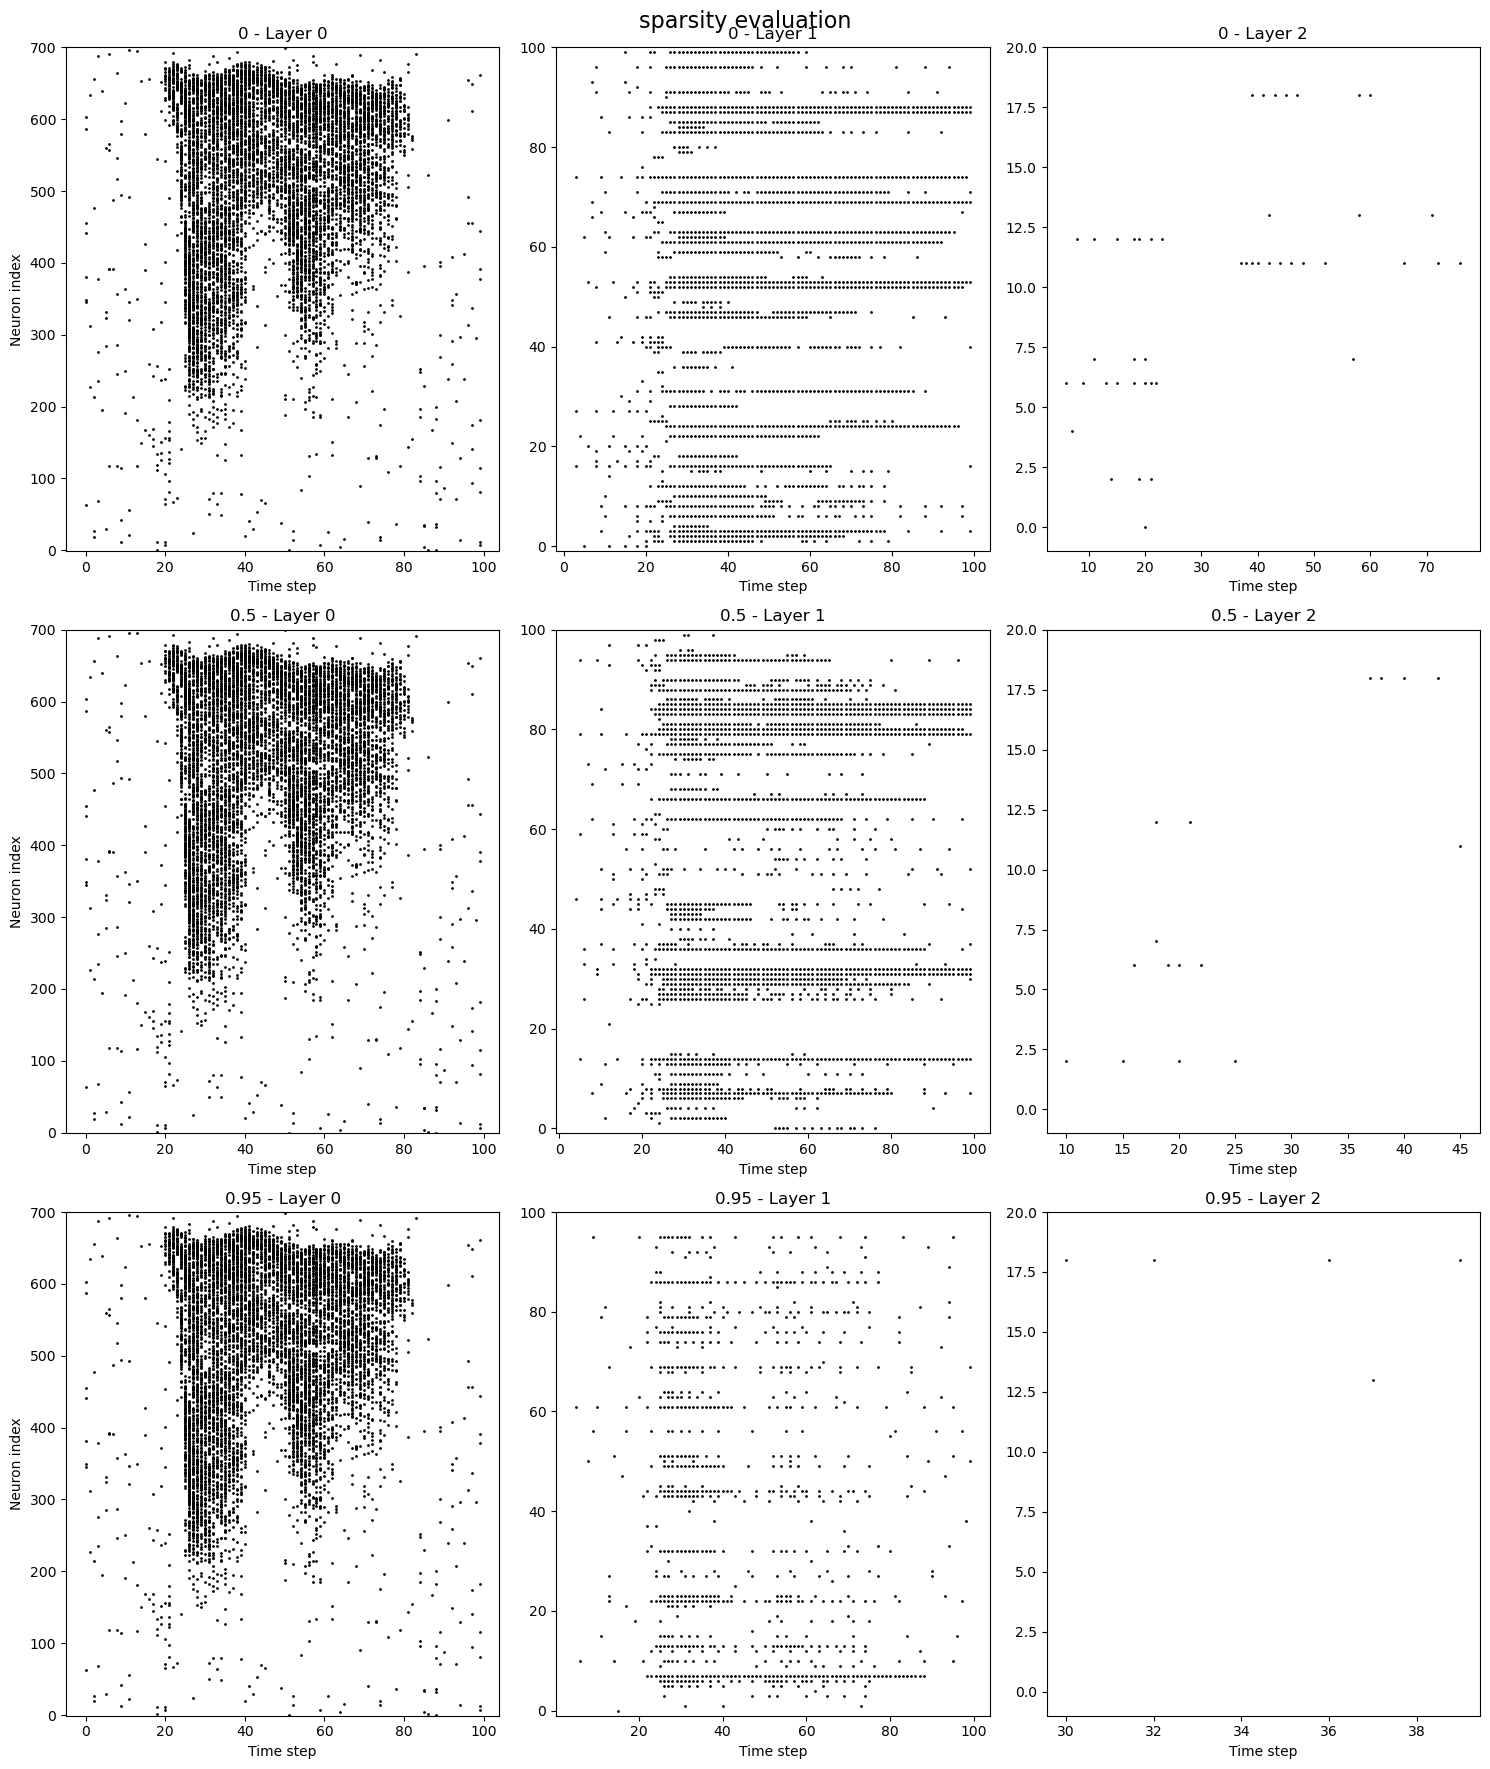

In [6]:
plot_layer_development(models, data, selection_index, [0, 0.5, 0.95], 'sparsity evaluation')